In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# -------------------------
# Helper: load UKB FID CSVs
# -------------------------
def load_fid(file_path, col_id, new_name, combine=False):
    """
    Load a UK Biobank FID file, rename selected column, and handle -0.0 / -1.0 fallback.
    """
    df = pd.read_csv(file_path)
    if combine:  
        # Use -0.0 if present, else fill with -1.0
        df[f'{col_id}-0.0'] = df[f'{col_id}-0.0'].combine_first(df[f'{col_id}-1.0'])
        df = df.rename(columns={'eid': 'IID', f'{col_id}-0.0': new_name})
    elif new_name == 'sex':
         df = df.rename(columns={'eid': 'IID', f'{col_id}-0.0': new_name})  
    else:
        df[f'{col_id}-2.0'] = df[f'{col_id}-2.0'].combine_first(df[f'{col_id}-0.0'])
        df = df.rename(columns={'eid': 'IID', f'{col_id}-2.0': new_name})
    return df[['IID', new_name]]

# -------------------------
# Load all required files
# -------------------------
train = pd.DataFrame()

files_info = [
    ('../fid31.csv', '31', 'sex', False),         # Sex (0=female,1=male)
    ('../fid21003.csv', '21003', 'age', False),   # Age
    ('../fid30720.csv', '30720', 'cystatinC', True),  # Cystatin C mg/L
    ('../fid30700.csv', '30700', 'creatinine', True), # Creatinine µmol/L
]

In [76]:
file_path, col_id, new_name, combine = files_info[0]
train = load_fid(file_path, col_id, new_name, combine)

for file_path, col_id, new_name, combine in files_info[1:]:
    df = load_fid(file_path, col_id, new_name, combine)
    train = pd.merge(train, df, on="IID", how="inner")

In [77]:
# -------------------------
# eGFR calculation function
# -------------------------
def ckdepi_2012_crcys(scr_mg_dl, scys_mg_l, age, sex_code, is_black=False):
    """
    CKD-EPI 2012 creatinine+cystatin C equation.
    sex_code: 0=female, 1=male (UKB coding)
    scr_mg_dl: creatinine in mg/dL
    scys_mg_l: cystatin C in mg/L
    """
    if pd.isna(scr_mg_dl) or pd.isna(scys_mg_l) or pd.isna(age) or pd.isna(sex_code):
        return np.nan
    
    if sex_code == 0:  # female
        kappa, alpha, sex_mult = 0.7, -0.248, 0.969
    else:              # male
        kappa, alpha, sex_mult = 0.9, -0.207, 1.0
    
    race_mult = 1.0 if not is_black else 1.08
    
    scr_k = scr_mg_dl / kappa
    scys_k = scys_mg_l / 0.8
    
    egfr = (
        135.0
        * (min(scr_k, 1) ** alpha)
        * (max(scr_k, 1) ** -0.601)
        * (min(scys_k, 1) ** -0.375)
        * (max(scys_k, 1) ** -0.711)
        * (0.995 ** float(age))
        * sex_mult
        * race_mult
    )
    return egfr

# -------------------------
# Compute eGFR
# -------------------------
train["scr_mg_dl"] = train["creatinine"] / 88.4  # µmol/L → mg/dL
train["scys_mg_l"] = train["cystatinC"]

train["egfr_crcys_ckdepi2012"] = train.apply(
    lambda r: ckdepi_2012_crcys(
        scr_mg_dl=r["scr_mg_dl"],
        scys_mg_l=r["scys_mg_l"],
        age=r["age"],
        sex_code=r["sex"],   # 0=female,1=male
        is_black=False       # White British
    ), axis=1
)

# -------------------------
# Save results
# -------------------------
train["egfr_crcys_ckdepi2012"] = train["egfr_crcys_ckdepi2012"].clip(lower=15, upper=140)

train[["IID", "egfr_crcys_ckdepi2012"]].to_csv("egfr_crcys_ckdepi2012.csv", index=False)

In [78]:
train.head()

,IID,sex,age,cystatinC,creatinine,scr_mg_dl,scys_mg_l,egfr_crcys_ckdepi2012
0,1000011,0,50.0,0.818,42.8,0.484163,0.818,109.811389
1,1000026,1,73.0,0.783,82.6,0.934389,0.783,92.284614
2,1000032,0,50.0,0.838,58.3,0.659502,0.838,99.977147
3,1000044,0,53.0,0.925,60.9,0.688914,0.925,90.817684
4,1000058,0,50.0,0.878,53.6,0.606335,0.878,98.754199


In [79]:
train.isnull().sum()

IID                          0
sex                          0
age                          0
cystatinC                31671
creatinine               31865
scr_mg_dl                31865
scys_mg_l                31671
egfr_crcys_ckdepi2012    32202
dtype: int64

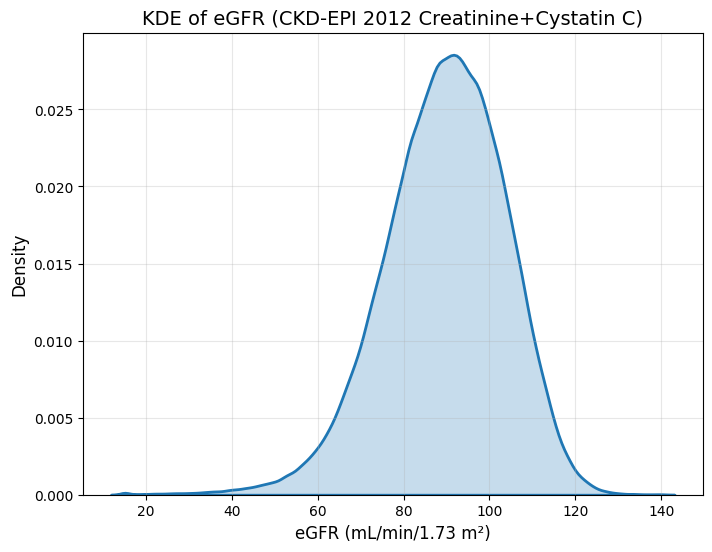

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values just in case
egfr_values = train["egfr_crcys_ckdepi2012"].dropna()

plt.figure(figsize=(8,6))
sns.kdeplot(egfr_values, fill=True, linewidth=2)

plt.title("KDE of eGFR (CKD-EPI 2012 Creatinine+Cystatin C)", fontsize=14)
plt.xlabel("eGFR (mL/min/1.73 m²)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

In [81]:
train = train[['IID', 'age', 'sex', 'egfr_crcys_ckdepi2012']]
train = train.rename(columns={'egfr_crcys_ckdepi2012':'egfr'})
train = train.dropna()

In [82]:
files_info = [
    ('../fid21001.csv', '21001', 'bmi', True),
    ('../fid30780.csv', '30780', 'hdl_c', False),
    ('../fid30690.csv', '30690', 'total_c', False),
    ('../fid20116.csv', '20116', 'smoking', True),
    ('../fid4080.csv', '4080', 'sbp', True),
]

for file_path, col_id, new_name, combine in files_info:
    df = pd.read_csv(file_path)
    
    if combine:  
        # First look at -2.0, fill missing with -0.0
        df[f'{col_id}-2.0'] = df[f'{col_id}-2.0'].combine_first(df[f'{col_id}-0.0'])
        df = df.rename(columns={'eid': 'IID', f'{col_id}-2.0': new_name})
    else:
        df = df.rename(columns={'eid': 'IID', f'{col_id}-0.0': new_name})
    
    df = df[['IID', new_name]]
    train = pd.merge(train, df, on='IID', how='inner')

    
meds = pd.read_csv('../fid6177.csv')
meds = meds.drop(['6177-3.0', '6177-3.0', '6177-3.0'], axis =1)


med_cols = meds.columns.drop('eid')
# Create binary flags
df_out = pd.DataFrame()
df_out['IID'] = meds['eid']

df_out['statin'] = meds[med_cols].isin([1.0]).any(axis=1).astype(int)
df_out['bp_tx']    = meds[med_cols].isin([2.0]).any(axis=1).astype(int)


train = pd.merge(train, df_out, on='IID', how='inner')

print(train.isnull().sum()[train.isnull().sum() > 0])

train.head()

bmi         1786
hdl_c       2172
total_c     1388
smoking      474
sbp        27200
dtype: int64


,IID,age,sex,egfr,bmi,hdl_c,total_c,smoking,sbp,statin,bp_tx
0,1000011,50.0,0,109.811389,25.1712,5.612,8.282,2.0,128.0,0,0
1,1000026,73.0,1,92.284614,23.3553,3.891,5.751,0.0,180.0,0,0
2,1000032,50.0,0,99.977147,32.2837,5.342,7.729,1.0,133.0,0,0
3,1000044,53.0,0,90.817684,32.3832,4.100,6.361,1.0,124.0,0,0
4,1000058,50.0,0,98.754199,32.3829,3.736,5.762,0.0,180.0,0,0


In [84]:
train = train.dropna()

In [85]:
dm = pd.read_csv('dm_case_control.csv')
train = pd.merge(train, dm, on='IID', how='inner')

In [87]:
train.head()

,IID,age,sex,egfr,bmi,hdl_c,total_c,smoking,sbp,statin,bp_tx,DM
0,1000011,50.0,0,109.811389,25.1712,5.612,8.282,2.0,128.0,0,0,0
1,1000026,73.0,1,92.284614,23.3553,3.891,5.751,0.0,180.0,0,0,0
2,1000032,50.0,0,99.977147,32.2837,5.342,7.729,1.0,133.0,0,0,0
3,1000044,53.0,0,90.817684,32.3832,4.100,6.361,1.0,124.0,0,0,0
4,1000058,50.0,0,98.754199,32.3829,3.736,5.762,0.0,180.0,0,0,0


In [89]:
# Convert UKB smoking to numeric, handle strings like "0.0" etc.
s = pd.to_numeric(train["smoking"], errors="coerce")

# Drop "-3 = prefer not to answer"
mask = s != -3
train = train.loc[mask].copy()
s = s.loc[mask]

# Map: 0=Never -> 0, 1=Previous -> 0, 2=Current -> 1
train["smoking"] = s.map({0: 0, 1: 0, 2: 1}).astype(int)

In [90]:
train["smoking"].value_counts()

smoking
0    393510
1     43397
Name: count, dtype: int64

In [91]:
train.head()

,IID,age,sex,egfr,bmi,hdl_c,total_c,smoking,sbp,statin,bp_tx,DM
0,1000011,50.0,0,109.811389,25.1712,5.612,8.282,1,128.0,0,0,0
1,1000026,73.0,1,92.284614,23.3553,3.891,5.751,0,180.0,0,0,0
2,1000032,50.0,0,99.977147,32.2837,5.342,7.729,0,133.0,0,0,0
3,1000044,53.0,0,90.817684,32.3832,4.100,6.361,0,124.0,0,0,0
4,1000058,50.0,0,98.754199,32.3829,3.736,5.762,0,180.0,0,0,0


In [94]:
cad = pd.read_csv('cad_case_control.csv')
cad = cad.rename(columns = {'Patient EID' :'IID'})
train = pd.merge(train, cad, on = 'IID', how = 'inner')

train.head()

,IID,age,sex,egfr,bmi,hdl_c,total_c,smoking,sbp,statin,bp_tx,DM,CAD
0,1000011,50.0,0,109.811389,25.1712,5.612,8.282,1,128.0,0,0,0,0
1,1000026,73.0,1,92.284614,23.3553,3.891,5.751,0,180.0,0,0,0,0
2,1000032,50.0,0,99.977147,32.2837,5.342,7.729,0,133.0,0,0,0,0
3,1000044,53.0,0,90.817684,32.3832,4.100,6.361,0,124.0,0,0,0,0
4,1000058,50.0,0,98.754199,32.3829,3.736,5.762,0,180.0,0,0,0,0


In [95]:
train['CAD'].value_counts()

CAD
0    388498
1     48409
Name: count, dtype: int64

In [97]:
train.to_csv('train_prevent.csv', sep = '\t', index = False)